# 事前分布の決定

In [224]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
import seaborn as sns
from scipy import stats

In [225]:
filepath = '../../../data/processed/df_filtered.xlsx'
df = pd.read_excel(filepath)

In [27]:
treatment_df = df[df['treatment_group'] == 1]
control_df = df[df['treatment_group'] == 0]
y_std = np.std(df['log_pop_star'])
mu_t = np.mean(treatment_df['log_pop_star'])
mu_c = np.mean(control_df['log_pop_star'])

## $\beta$ の事前分布

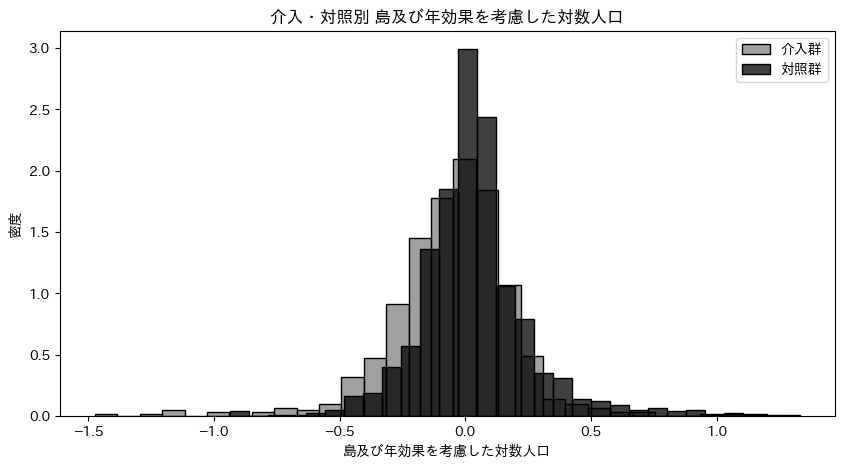

In [420]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(treatment_df['log_pop_star'], bins=30, label='介入群', ax=ax, stat='density', color='gray')
sns.histplot(control_df['log_pop_star'], bins=30, label='対照群', ax=ax, stat='density', color='black')
ax.set_title('介入・対照別 島及び年効果を考慮した対数人口')
ax.set_xlabel('島及び年効果を考慮した対数人口')
ax.set_ylabel('密度')
ax.legend()
plt.show()

このグラフは島効果と年効果を考慮した対数人口を介入群と対照群に分けたものだ．

両者は重なっているが，介入群の方が対照群よりも少ない方に偏っている．

その対数人口の平均値をみると，処置群は $-0.05$，対照群は $0.03$ であり，その差は $-0.08$である．
標準偏差は介入群は0.25，対照群は0.23であり，介入群の方がばらつきが大きいといえる．
その他の統計量は介入群の方が小さい値を示している．

したがって，架橋は人口を減少させる可能性があるが，せいぜい数%であり，高くても20%以上の差はないと考えられる．

| | 介入群 | 対照群 | 差 |
| :---: | :---: | :---: | :---: |
| 平均 | $-0.05$ | $0.03$ | $-0.08$ |
| 標準偏差 | $0.25$ | $0.23$ | $0.02$ |
| 最小 | $-1.47$ | $-0.93$ | $-0.54$ |
| 中央 | $-0.03$ | $0.02$ | $-0.05$ |
| 最大 | $1.20$ | $1.33$ | $-0.13$ |


In [48]:
treatment_df['log_pop_star'].describe()

count    664.000000
mean      -0.052576
std        0.252274
min       -1.472047
25%       -0.179845
50%       -0.028401
75%        0.091517
max        1.198952
Name: log_pop_star, dtype: float64

In [49]:
control_df['log_pop_star'].describe()

count    1059.000000
mean        0.032966
std         0.230109
min        -0.936948
25%        -0.080112
50%         0.021100
75%         0.113693
max         1.328346
Name: log_pop_star, dtype: float64

以上の情報を用いて事前分布を決定する．

介入効果を示すパラメータ $\beta$ は次のように設定する．

$$\beta \sim \mathcal{N}(0, 0.1^2)$$

期待値は 0 とする．まずはパラメータの正負に関心があるため，どちらかに偏った情報を持たせないようにする．

標準偏差は0.1とする．次のグラフを見てほしい．標準偏差が0.1の場合，95%の確率で-0.196から0.196の間に収まる．

指数に変換すると，架橋が人口に与える影響は $17.80\%$ の減少から $21.65\%$ の増加の間に収まる事になる．

介入群と処置群の両群の平均値の差が $-0.08$ であったことを考慮すれば，この事前分布は十分に広い範囲をカバーしているといえる．

また， $\beta \sim \text{Uniform}(-0.2, 0.2)$ といった一様分布ではなく正規分布を選んだ理由は，$\beta$ が $0.2$ と大きな値を取る確率と $0$ に近い値を取る確率は等価ではなく，大きな値を取る確率が小さいことを反映させるためである．

In [84]:
effect = 0.196
log_effect = np.log(effect + 1)

print(f'もし効果が {effect:.2%} の場合')
print(f'βは {log_effect:.3f}')

もし効果が 19.60% の場合
βは 0.179


In [116]:
log_effect = 0.196
effect = np.exp(log_effect) - 1

print(f'もしβが {log_effect:.2f} の場合')
print(f'効果は {effect:.2%}')
print(f'つまり，人口は {effect+1:.2f} 倍になる．')

もしβが 0.20 の場合
効果は 21.65%
つまり，人口は 1.22 倍になる．


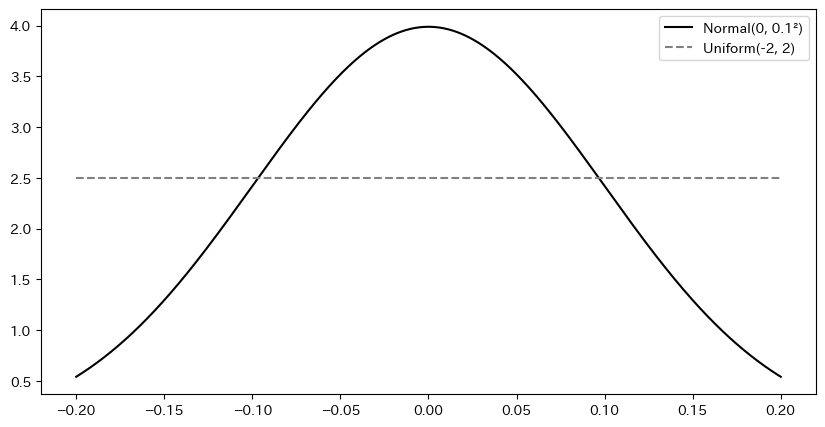

In [256]:
x = np.linspace(-0.2, 0.2, 1000)
# normal
mu = 0
sigma = 0.1
normal_pdf = stats.norm.pdf(x, loc=mu, scale=sigma)
# uniform
low = -0.2
high = 0.2
uniform_pdf = stats.uniform.pdf(x, loc=low, scale=high - low)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, normal_pdf, label='Normal(0, 0.1²)', color='black')
ax.plot(x, uniform_pdf, label='Uniform(-2, 2)', color='gray', linestyle='--')
ax.legend()
plt.show()

## 誤差分散の事前分布

誤差分散の事前分布を決定する．

被説明変数は島・時間効果を考慮した対数人口であり，その分散は $0.24^2$ である．

しかしながら，不均一分散を考慮する必要がある．

被説明変数の島別の標準偏差の基本統計量とヒストグラムは以下の通りだ．


| 平均 | 標準偏差 | 最小 | 中央 | 最大 |
| :---: | :---: | :---: | :---: | :---: |
| $0.19$| $0.15$ | $0.02$ | $0.15$ | $0.79$ |


島ごとの標準偏差は0から0.2の間に集中しているが，0.3以上の値を取る島もいくつか存在する．

したがって，島ごとに誤差分散が異なるように事前分布を設定する必要がある．

$$
\begin{aligned}
\sigma_i &\sim \text{C}^+(\sigma_{\text{global}}^2) \\
\end{aligned}
$$

ここで，$\text{C}^+$ は半コーシー分布を表し，$\sigma_{\text{global}}$ はハイパーパラメータである．

$\sigma_{global}^2$ は島間を横断した誤差分散の期待値であり，島内の誤差分散 $\sigma_i^2$ はこの期待値を中心に分布する．

$\sigma_{global} \sim \text{C}^+(0.15^2)$ と設定する．

このハイパーパラメータは，被説明変数の島別標準偏差の標準偏差が $0.15^2$ であることを考慮して設定した．

なお，コーシー分布は裾野の重い確率分布であり，正規分布に比べて情報が弱い事前分布である．したがって過適合のリスクを緩和する狙いもある．

以下のグラフを参考されたい．

In [401]:
y_std_i = df.groupby('island_ids')['log_pop_star'].std()
y_std_i.describe()

count    94.000000
mean      0.191469
std       0.146893
min       0.020647
25%       0.090140
50%       0.151969
75%       0.235365
max       0.792815
Name: log_pop_star, dtype: float64

Text(0.5, 1.0, 'Standard deviation of log population per island')

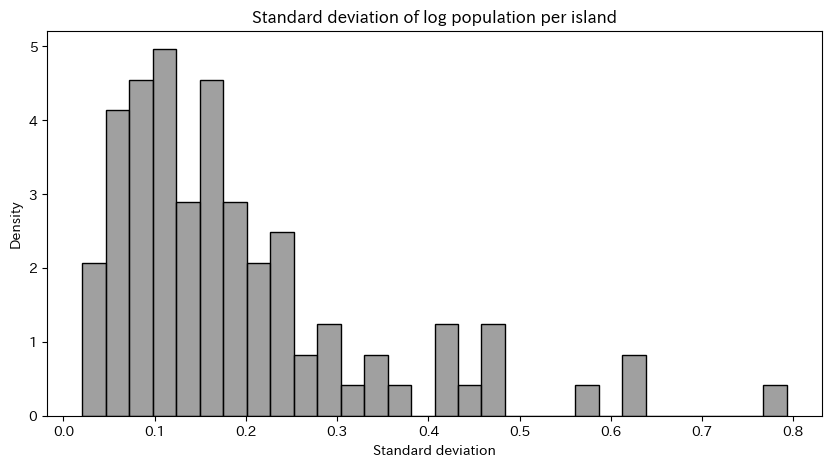

In [298]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
sns.histplot(y_std_i, bins=30, ax=ax, color='gray', stat='density')
ax.set_xlabel('Standard deviation')
ax.set_title('Standard deviation of log population per island')

In [204]:
# パラメータ
sigma = 0.1
value = 0.25

# 半正規分布の累積分布関数を使用して確率を計算
probability = stats.halfnorm.cdf(value, scale=sigma)

print(f"半正規分布 N(0, {sigma}) が {value} 以下の値を取る確率: {probability:.4f}")

半正規分布 N(0, 0.1) が 0.25 以下の値を取る確率: 0.9876


<>:21: SyntaxWarning: invalid escape sequence '\s'
<>:21: SyntaxWarning: invalid escape sequence '\s'
/tmp/ipykernel_9338/882445759.py:21: SyntaxWarning: invalid escape sequence '\s'
  ax.set_title('ハイパーパラメータ $\sigma^2_{\\text{global}}$ の設定')


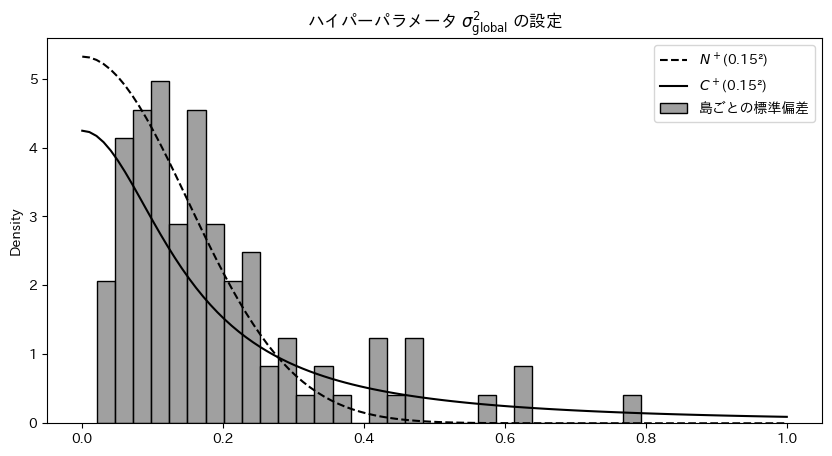

In [412]:
x = np.linspace(0, 1, 100)

sigma = 0.15

# half-normal
half_normal_pdf = stats.halfnorm.pdf(x, scale=sigma)

# half-cauchy
half_cauchy_pdf = stats.halfcauchy.pdf(x, scale=sigma)

# inverse-gamma
alpha = 2.25
beta = 0.2
inverse_gamma_pdf = stats.invgamma.pdf(x, a=alpha, scale=beta)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(y_std_i, bins=30, ax=ax, color='gray', stat='density', label='島ごとの標準偏差')
ax.plot(x, half_normal_pdf, label=f'$N^+$({sigma}²)', color='black', linestyle='--')
ax.plot(x, half_cauchy_pdf, label=f'$C^+$({sigma}²)', color='black', linestyle='-')
# ax.plot(x, inverse_gamma_pdf, label=f'InverseGamma({alpha, beta})', color='black', linestyle='-.')
ax.set_title('ハイパーパラメータ $\sigma^2_{\\text{global}}$ の設定')
ax.set_xlabel('')
ax.legend()
plt.show()

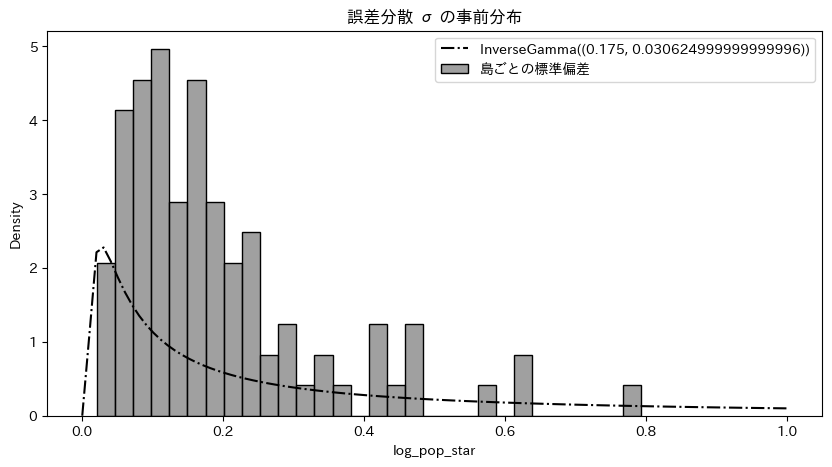

In [ ]:
x = np.linspace(0, 1, 100)

sigma = 0.3

# half-normal
half_normal_pdf = stats.halfnorm.pdf(x, scale=sigma)

# half-cauchy
half_cauchy_pdf = stats.halfcauchy.pdf(x, scale=sigma)

# inverse-gamma
sigma_grobal = 0.175
k = 1
alpha = k * sigma_grobal
beta = k * sigma_grobal ** 2
inverse_gamma_pdf = stats.invgamma.pdf(x, a=alpha, scale=beta)

fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(y_std_i, bins=30, ax=ax, color='gray', stat='density', label='島ごとの標準偏差')
# ax.plot(x, half_normal_pdf, label=f'Half-Normal({sigma})', color='black', linestyle='-')
# ax.plot(x, half_cauchy_pdf, label=f'Half-Cauchy({sigma})', color='black', linestyle='--')
ax.plot(x, inverse_gamma_pdf, label=f'InverseGamma({alpha, beta})', color='black', linestyle='-.')
ax.set_title('誤差分散 σ の事前分布')
ax.legend()
plt.show()

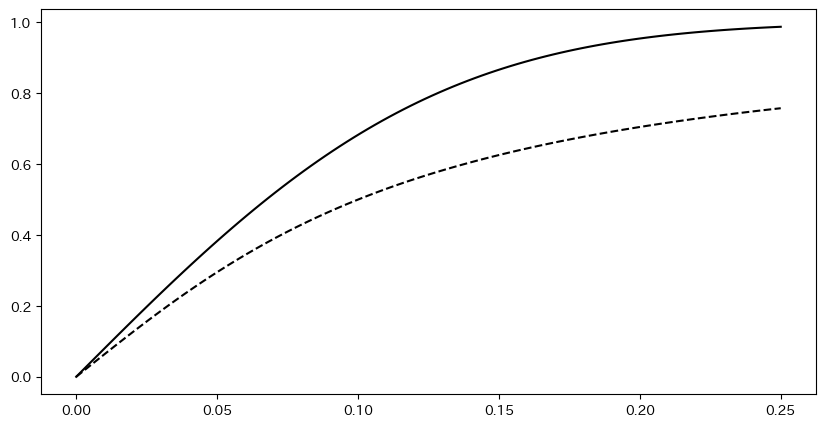

In [217]:
x = np.linspace(0, 0.25, 100)
sigma = 0.1
half_normal_cdf = stats.halfnorm.cdf(x, scale=sigma)
half_cauchy_cdf = stats.halfcauchy.cdf(x, scale=sigma)

fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(x, half_normal_cdf, label=f'Half-Normal({sigma})', color='black', linestyle='-')
ax.plot(x, half_cauchy_cdf, label=f'Half-Cauchy({sigma})', color='black', linestyle='--')

## 尤度

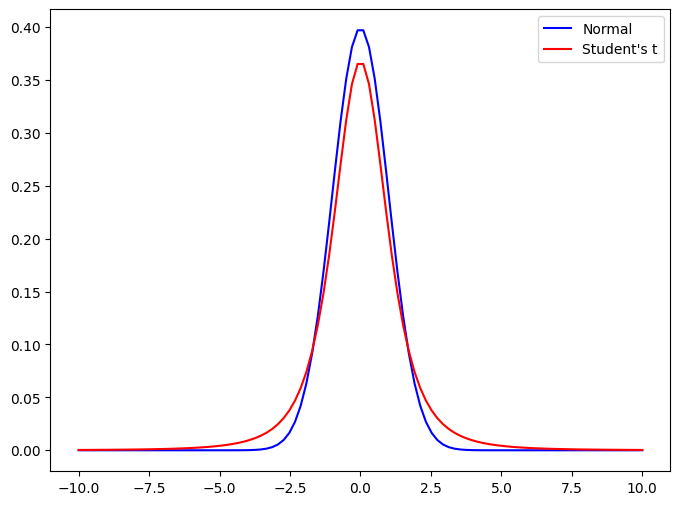

In [ ]:
x = np.linspace(-10, 10, 100)
# 各分布の確率密度関数
normal_pdf = stats.norm.pdf(x, loc=0, scale=1)
t_pdf = stats.t.pdf(x, df=3, loc=0, scale=1)
# cauchy_pdf = cauchy.pdf(x, loc=0, scale=1)

plt.figure(figsize=(8, 6))
plt.plot(x, normal_pdf, label='Normal', color='blue')
plt.plot(x, t_pdf, label='Student\'s t', color='red')
# plt.plot(x, cauchy_pdf, label='Cauchy', color='green')
plt.legend()
plt.show()